In [1]:
import pandas as pd
import numpy as np

In [6]:
#Scraping the data into a pandas dataframe
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df.head(12)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [7]:
#Excluding rows where Borough is not assigned
condition = df["Borough"] != "Not assigned"
df = df[condition]
df.head(10)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [17]:
#Grouping cells by Postal Code
df_grouped = df.groupby('Postal Code', sort=False).agg(', '.join)
df_grouped.head(10)

,Borough,Neighbourhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
M1B,Scarborough,"Malvern, Rouge"
M3B,North York,Don Mills
M4B,East York,"Parkview Hill, Woodbine Gardens"


In [20]:
#If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough
condition = df_grouped['Neighbourhood'] =='Not assigned'
df_grouped.loc[condition, 'Neighbourhood'] = df_grouped.loc[condition, 'Borough']

df_grouped.reset_index(inplace=True)
df_grouped.head(10)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [ ]:
df_grouped.shape

<h1>Part 2: Geocoding</h1>

In [22]:
!pip install geocoder
import geocoder

In [23]:
#Adding new columns to store the values of Latitude and Longitude
df_grouped['Longitude'] = None
df_grouped['Latitude'] = None

In [25]:
#Now, assigning lat & long values

for i, pc in enumerate(df_grouped['Postal Code']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(pc))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df_grouped.loc[i, 'Latitude'] = latitude
    df_grouped.loc[i, 'Longitude'] = longitude


In [27]:
df_grouped.head(12)

,Postal Code,Borough,Neighbourhood,Longitude,Latitude
0,M3A,North York,Parkwoods,-79.3299,43.7525
1,M4A,North York,Victoria Village,-79.3131,43.7306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",-79.3626,43.6551
3,M6A,North York,"Lawrence Manor, Lawrence Heights",-79.4504,43.7233
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",-79.3919,43.6625
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",-79.5283,43.6626
6,M1B,Scarborough,"Malvern, Rouge",-79.1966,43.8114
7,M3B,North York,Don Mills,-79.3619,43.7492
8,M4B,East York,"Parkview Hill, Woodbine Gardens",-79.3119,43.7072
9,M5B,Downtown Toronto,"Garden District, Ryerson",-79.378,43.6574


<h1>Part 3: Clustering</h1> 

In [29]:
from sklearn import cluster
from sklearn.decomposition import PCA

X = np.stack((df_grouped['Latitude'], df_grouped['Longitude']), axis=1)#Features for clsutering model

#Model parameters
K=3
nIterations= 300

#K-Means model intialization, and training
model = cluster.KMeans(init="k-means++", n_clusters=K, max_iter=nIterations)
model.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

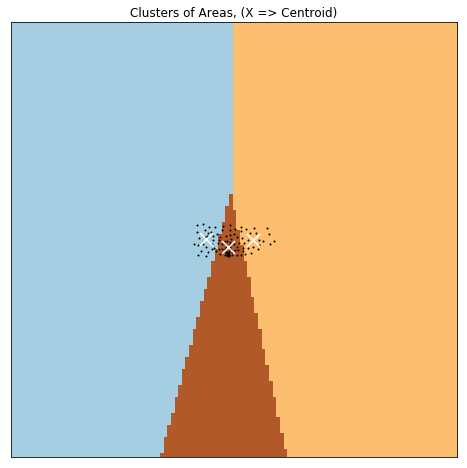

In [31]:
#Visualization of clusters
#Code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

import matplotlib.pyplot as plt

X_transformed = PCA(n_components=2).fit_transform(X)
model = cluster.KMeans(init='k-means++', n_clusters=K,max_iter=nIterations, random_state=42)#This time we use the whole dataset
model.fit(X_transformed)

h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary
x_min, x_max = X_transformed[:, 0].min() - 1, X_transformed[:, 0].max() + 1
y_min, y_max = X_transformed[:, 1].min() - 1, X_transformed[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_transformed[:, 0], X_transformed[:, 1], 'k.', markersize=2)
# Plot the centroids
centroids = model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clusters of Areas, (X => Centroid)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()